# 24th September - Motor Pot/Prep Dual Reaches

This notebook trains networks on dual reach tasks, then studies how aligned the preparatory and potent subspaces are. 

The data is constructed to contain all combinations of the following parameters.
1. Prep_periods, how long before the first movement is the cue provided.
2. Delay_two, how long is the delay between first go cue and second cue
3. prep_delays, how long is the time between second cue and movement

Currently it is setup such that preparation and movement don't overlap in time, so their neural encodings do overlap. To make them overlap in time, and hence the subspaces orthogonalise, set prep_delays to contain a number smaller than 2 (the length of the action).

In [466]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import vmap, value_and_grad, grad, jit, random
import jax.nn as jnn
from mpl_toolkits.mplot3d import Axes3D
import math
import optax
import scipy
import jax

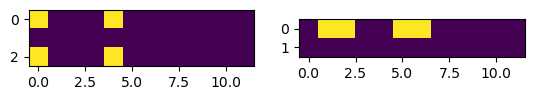

In [503]:
prep_periods = [1,3]
delay_two = [0,2] # [0, 2]
prep_delays = [3,4]
num_reaches = 2
T = max(prep_periods) + max(delay_two) + max(prep_delays) + 3
num_trials = num_reaches*(num_reaches+1)*len(prep_periods)*len(delay_two)*len(prep_delays)

outputs = jnp.zeros([num_reaches,num_trials,T])
inputs = jnp.zeros([num_reaches+1,num_trials,T])

# Create inpout and output
for prep_ind, prep_period in enumerate(prep_periods):
    for delay_ind, delay_period in enumerate(delay_two):
        for prep_delay_ind, prep_delay in enumerate(prep_delays):
            trial_start_ind = prep_ind*num_reaches*(num_reaches+1)*len(delay_two)*len(prep_delays) + delay_ind*num_reaches*(num_reaches+1)*len(prep_delays)+ prep_delay_ind*num_reaches*(num_reaches+1)
            trial_ind = 0
            for reach1 in range(num_reaches):
                for reach2 in range(num_reaches+1):
                    # First reach
                    outputs = outputs.at[reach1,trial_start_ind + trial_ind,prep_period:prep_period+2].set(1)
                    inputs = inputs.at[reach1,trial_start_ind+trial_ind,:prep_period].set(1)
                    inputs = inputs.at[num_reaches,trial_start_ind+trial_ind,prep_period-1].set(1)
    
                    # Second reach
                    if reach2 < num_reaches:
                        outputs = outputs.at[reach2,trial_start_ind + trial_ind,prep_period+delay_period+1+prep_delay:prep_period+delay_period+1+prep_delay+2].set(1)
                        inputs = inputs.at[reach2,trial_start_ind+trial_ind,prep_delay+prep_period:prep_period+delay_period+1+prep_delay].set(1)
                        inputs = inputs.at[num_reaches,trial_start_ind+trial_ind,prep_delay+prep_period+delay_period].set(1)
                    trial_ind += 1
                
plot_trial = 0
plt.subplot(1,2,1)
plt.imshow(inputs[:,plot_trial,:])

plt.subplot(1,2,2)
plt.imshow(outputs[:,plot_trial,:])

In [504]:
outputs.shape

(2, 48, 12)

In [505]:
# Define initialising functions, and losses
N = 10 # Number of neurons
I_Size = num_reaches+1
O_Size = num_reaches
random_seed = 2

# Initialise W orthogonal, and others random
def initialise_weights(N, random_seed, init_scale = 0.01):
    W = jnp.zeros([N, N+1])
    key = random.PRNGKey(random_seed)

    W = W.at[:,-1].set(random.normal(key, (N,))*init_scale)
    Wp = random.normal(key, (N,N))
    Wp, S, V = jnp.linalg.svd(Wp)
    W = W.at[:,:N].set(Wp)

    R = random.normal(key, (O_Size, N+1))*init_scale
    I = random.normal(key, (N, I_Size+1))*init_scale
    params = {'W':W, 'R':R, 'I':I}
    
    return params

@jit
def generate_rep(params, inputs, random_seed):
    # Neurons by time points by trials
    g = jnp.zeros([N, T, num_trials])
    g = g.at[:,0,:].set(jnn.relu(params['I'][:,:-1]@inputs[:,:,0] + params['I'][:,-1][:,None]))

    # For rest we just recurrently go around.
    key = random.PRNGKey(random_seed)
    subkey, key = random.split(key)
    for t in range(1,T):
        input_current = params['W'][:,:-1]@g[:,t-1,:] + params['W'][:,-1][:,None] +params['I'][:,:-1]@inputs[:,:,t] + params['I'][:,-1][:,None] 
        g = g.at[:,t,:].set(jnn.relu(input_current))
    return g

@jit
def loss_weight(W):
    return jnp.sum(jnp.power(W[:,:-1], 2))

@jit
def loss_act(g):
    return jnp.mean(jnp.sum(jnp.power(g, 2), 0))

@jit
def loss_fit(g, R, outputs):
    preds = jnp.einsum('ij, jkl -> ilk', R[:,:-1], g) + R[:,-1][:,None,None]
    return jnp.mean(jnp.sum(jnp.power(outputs - preds, 2), 0))

@jit
def generate_pred(params, g):
    preds = jnp.einsum('ij, jkl -> ilk', params['R'][:,:-1], g) + params['R'][:,-1][:,None,None]
    return preds

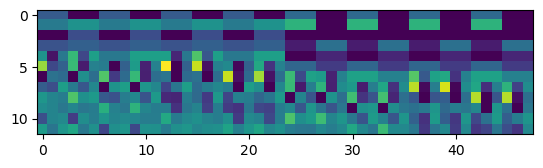

In [506]:
params = initialise_weights(N, random_seed)
g = generate_rep(params, inputs, random_seed)

plt.imshow(g[6,:,:])

In [507]:
mu_fit = 10000
mu_G = 1
mu_W = 1
fit_thresh = 0

@jit
def loss(params, inputs, outputs, random_seed):
    g = generate_rep(params, inputs, random_seed)
    
    fitting_loss = loss_fit(g, params['R'], outputs)  

    weight_loss = loss_weight(params['W'])
    weight_loss += loss_weight(params['R'])
    weight_loss += loss_weight(params['I'])
    
    return mu_fit*jnn.tanh(fitting_loss-fit_thresh) + mu_G*loss_act(g) + mu_W*weight_loss

@jit
def update(params, inputs, outputs, opt_state, random_seed):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, inputs, outputs, random_seed)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, value

N = 30
random_seed = 5234218
learning_rate = 1e-3 #2e-5
scale = 0.1
key = random.PRNGKey(random_seed)

re_init = True
if re_init:
    optimizer = optax.adam(learning_rate)
    params = initialise_weights(N, random_seed, init_scale = scale)
    opt_state = optimizer.init(params)
    min_loss = np.infty
else:
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(params)
print(loss(params, inputs, outputs, random_seed))


3130.339


In [510]:
num_timesteps = 10000000
print_iter = 10000
noise_scale = 0

for step in range(num_timesteps):
    params, opt_state, loss_val = update(params,  inputs, outputs, opt_state, random_seed)


    if step % print_iter == 0:
        g = generate_rep(params, inputs, random_seed)
            
        fitting_loss = loss_fit(g, params['R'], outputs)  
    
        weight_loss_W = loss_weight(params['W'])
        weight_loss_R = loss_weight(params['R'])
        weight_loss_I = loss_weight(params['I'])

        L_a = loss_act(g)

        loss_comp = mu_fit*jnn.relu(fitting_loss-fit_thresh) + mu_G*L_a + mu_W*(weight_loss_R + weight_loss_I + weight_loss_W)
        print(f"Step {step}, Loss: {loss_val:.5f}, Fit: {fitting_loss:.5f}, Act: {L_a:.5f}, Wei: {weight_loss_W:.5f}, R: {weight_loss_R:.5f}, I: {weight_loss_I:.5f}")

        min_this_step = 0

    if loss_val < min_loss:
        params_best = params
        min_loss = loss_val
        if min_this_step == 0:
            print(f'New min! {loss_val}')
            min_this_step = 1
            

Step 0, Loss: 9.09855, Fit: 0.00000, Act: 0.59731, Wei: 3.88638, R: 2.58447, I: 1.99009
New min! 9.079266548156738
Step 10000, Loss: 8.71416, Fit: 0.00000, Act: 0.63285, Wei: 3.68189, R: 2.49006, I: 1.87642
New min! 8.711125373840332
Step 20000, Loss: 8.55715, Fit: 0.00000, Act: 0.65699, Wei: 3.60473, R: 2.45773, I: 1.80279
New min! 8.556867599487305
Step 30000, Loss: 8.55006, Fit: 0.00000, Act: 0.66004, Wei: 3.59051, R: 2.46116, I: 1.80418
New min! 8.548487663269043
Step 40000, Loss: 8.54536, Fit: 0.00000, Act: 0.66231, Wei: 3.58171, R: 2.46497, I: 1.80454
New min! 8.54475212097168
Step 50000, Loss: 8.54358, Fit: 0.00000, Act: 0.66260, Wei: 3.57732, R: 2.46621, I: 1.80588
New min! 8.541983604431152
Step 60000, Loss: 8.54211, Fit: 0.00000, Act: 0.66194, Wei: 3.57361, R: 2.46780, I: 1.80704
New min! 8.53990650177002
Step 70000, Loss: 8.53954, Fit: 0.00000, Act: 0.66084, Wei: 3.56546, R: 2.46969, I: 1.81144
New min! 8.534671783447266
Step 80000, Loss: 8.53264, Fit: 0.00000, Act: 0.66109,

KeyboardInterrupt: 

8.501207


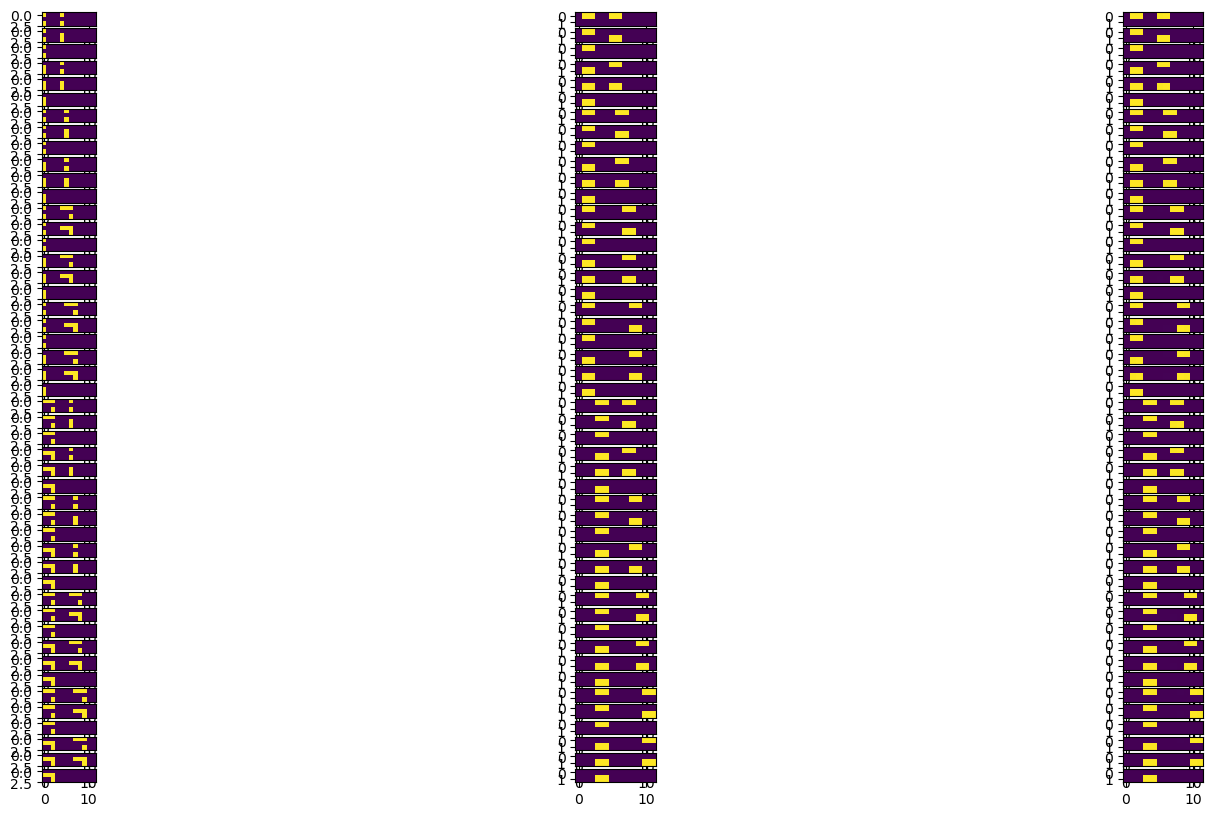

In [511]:
g = generate_rep(params_best, inputs, random_seed)
preds = generate_pred(params_best, g)

print(min_loss)

plt.figure(figsize = (20, 10))
for ang in range(num_trials):
    plt.subplot(num_trials, 3, ang*3 + 1)
    plt.imshow(inputs[:,ang,:])
    
    plt.subplot(num_trials, 3, ang*3 +2)
    plt.imshow(outputs[:,ang,:])

    plt.subplot(num_trials, 3, ang*3 + 3)
    plt.imshow(preds[:,ang,:])

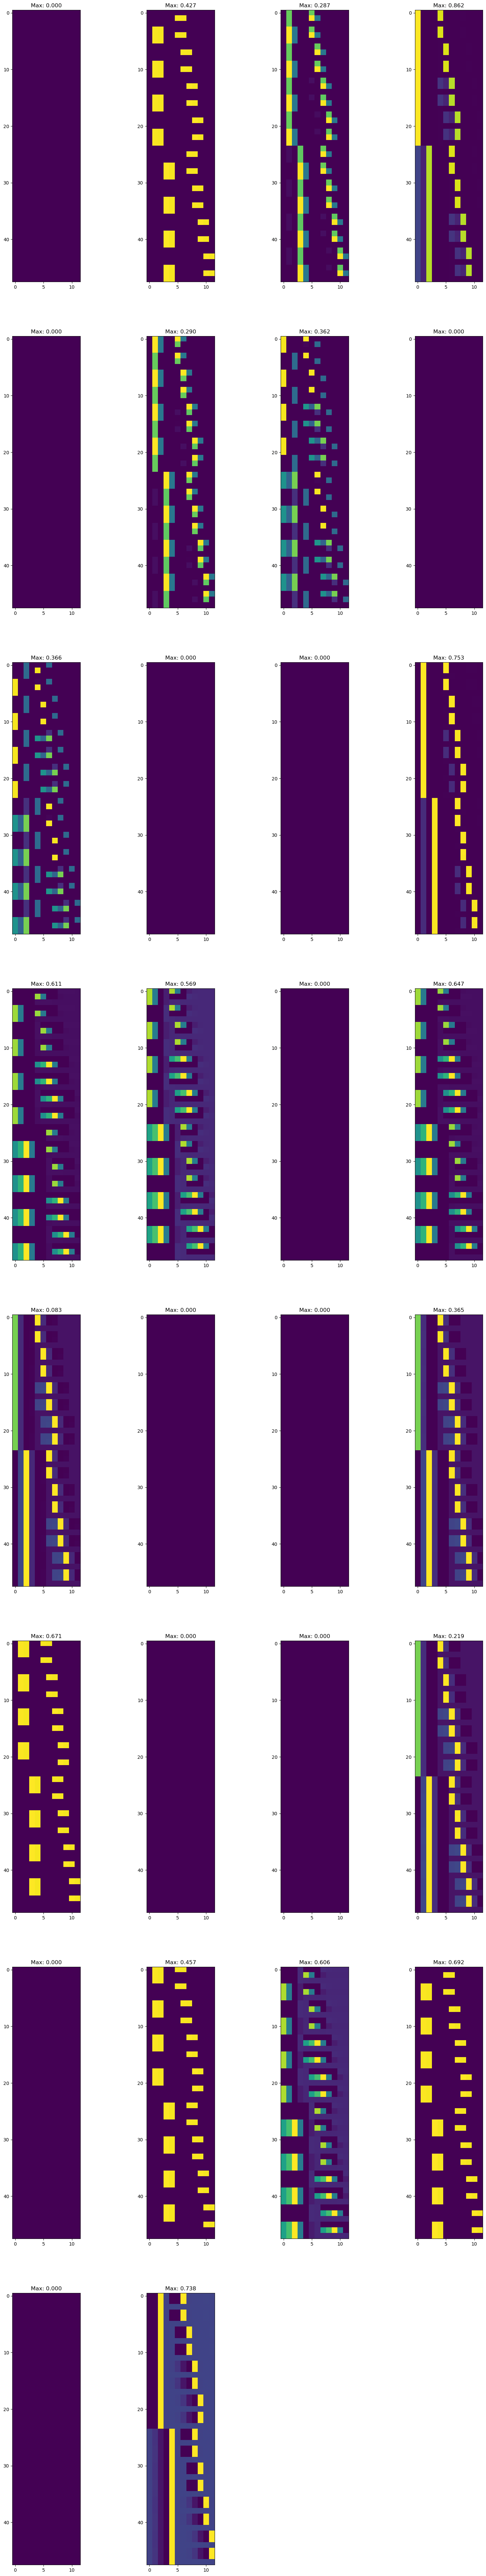

In [512]:
plt.figure(figsize = (20,100))
rows = 4
for neuron in range(N):
    plt.subplot(int(N/rows)+1,rows, neuron+1)
    plt.imshow(g[neuron,:,:].T)
    plt.title(f'Max: {np.max(g[neuron,:,:]):.3f}')

In [513]:
def get_PCs(vecs, num_eigs = 2):
    vecs = vecs - np.mean(vecs, axis = 1)[:,None]
    covar = vecs@vecs.T
    eigvals, eigvecs = np.linalg.eig(covar)
    
    ordering = np.argsort(eigvals)[::-1]
    #print(f"Propotion of Activity Kept: {np.sum(eigvals[ordering[:2]])/np.sum(eigvals)}")
    return np.real(eigvecs[:,ordering[:num_eigs]]), np.real(eigvals[ordering[:num_eigs]])


Pot in Prep: 0.4657047390937805
Prep in Pot: 0.594356894493103


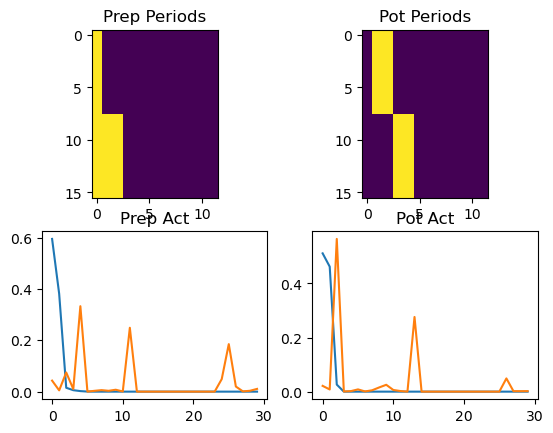

In [514]:
def plot_var(vecs, PCs):
    demeaned_act = vecs - np.mean(vecs, axis = 1)[:,None]
    total_var = np.sum(np.power(demeaned_act, 2))
    PC_var = np.sum(np.power(PCs.T@demeaned_act, 2), axis = 1)/total_var
    plt.plot(PC_var)
    return PC_var
    
# Now focus on extracting subspaces only from single reach trials
relevant_trials = [num_reaches + i*(num_reaches+1) for i in range(int(num_trials/(num_reaches+1)))]
g_single_reach = g[:,:,relevant_trials]
inputs_single_reach = inputs[:,relevant_trials,:]
outputs_single_reach = outputs[:,relevant_trials,:]

prep_period_times = np.logical_and(np.any(np.abs(inputs_single_reach) > 0.01, axis = 0), np.all(np.abs(outputs_single_reach)<0.01 , axis = 0))
#pot_period_times = np.logical_or(np.logical_and(np.all(np.abs(inputs_single_reach) < 0.01,axis=0), np.any(np.abs(outputs_single_reach)>0.01, axis = 0)), np.logical_and(np.all(np.abs(inputs_single_reach) < 0.01,axis=0), np.all(np.abs(outputs_single_reach)<0.01, axis = 0)))
pot_period_times = np.logical_and(np.all(np.abs(inputs_single_reach) < 0.01,axis=0), np.any(np.abs(outputs_single_reach)>0.01, axis = 0))

plt.subplot(2,2,1)
plt.imshow(prep_period_times)
plt.title('Prep Periods')

plt.subplot(2,2,2)
plt.imshow(pot_period_times)
plt.title('Pot Periods')

prep_act = g_single_reach[:,prep_period_times.T]
prep_act = np.reshape(prep_act, [N, int(prep_act.size/N)])
pot_act = g_single_reach[:,pot_period_times.T]
pot_act = np.reshape(pot_act, [N, int(pot_act.size/N)])

num_eigs = N

prep_PCs, prep_PC_vals = get_PCs(prep_act, num_eigs = num_eigs)
pot_PCs, pot_PC_vals = get_PCs(pot_act, num_eigs = num_eigs)

plt.subplot(2,2,3)
prep_in_prep_var = plot_var(prep_act, prep_PCs)
pot_in_prep_var = plot_var(pot_act, prep_PCs)
thresh_var = 0.001

plt.title('Prep Act')
print(f'Pot in Prep: {np.sum(pot_in_prep_var[prep_in_prep_var > thresh_var])}')

plt.subplot(2,2,4)
pot_in_pot_var = plot_var(pot_act, pot_PCs)
prep_in_pot_var = plot_var(prep_act, pot_PCs)

plt.title('Pot Act')
print(f'Prep in Pot: {np.sum(prep_in_pot_var[pot_in_pot_var > thresh_var])}')


In [ ]:
plt.figure(figsize = (20,40))
rows = 4
for neuron in range(N):
    plt.subplot(int(N/rows)+1,rows, neuron+1)
    plt.imshow(g_single_reach[neuron,:,:].T)
    plt.title(f'Max: {np.max(g[neuron,:,:]):.3f}')

In [ ]:
# Now measure how much prep and potent activity is in each of these PCs for dual-reach task
prep_period_times = np.logical_and(np.any(np.abs(inputs) > 0.01, axis = 0), np.all(np.abs(outputs)<0.01 , axis = 0))
#pot_period_times = np.logical_or(np.logical_and(np.all(np.abs(inputs) < 0.01,axis=0), np.any(np.abs(outputs)>0.01, axis = 0)), np.logical_and(np.all(np.abs(inputs) < 0.01,axis=0), np.all(np.abs(outputs)<0.01, axis = 0)))
pot_period_times = np.any(np.abs(outputs)>0.01, axis = 0)

plt.subplot(2,2,1)
plt.imshow(prep_period_times)
plt.title('Prep Periods')

plt.subplot(2,2,2)
plt.imshow(pot_period_times)
plt.title('Pot Periods')

prep_act = g[:,prep_period_times.T]
prep_act = np.reshape(prep_act, [N, int(prep_act.size/N)])
pot_act = g[:,pot_period_times.T]
pot_act = np.reshape(pot_act, [N, int(pot_act.size/N)])

plt.subplot(2,2,3)
prep_in_prep_var_dual = plot_var(prep_act, prep_PCs)
pot_in_prep_var_dual = plot_var(pot_act, prep_PCs)
print(f'Pot in Prep: {np.sum(pot_in_prep_var_dual[prep_in_prep_var > thresh_var])}')

plt.title('Prep Act')

plt.subplot(2,2,4)
pot_in_pot_var_dual = plot_var(pot_act, pot_PCs)
prep_in_pot_var_dual = plot_var(prep_act, pot_PCs)

plt.title('Pot Act')
print(f'Prep in Pot: {np.sum(prep_in_pot_var_dual[pot_in_pot_var > thresh_var])}')


In [ ]:
# Time to make plots
trials_plot = [33]
colours = ['blue', 'orange']
lw = 7
for trial_id in trials_plot:
    plt.subplot(3,1,1)
    
    for i in range(2):
        plt.plot(inputs[i,trial_id,:],c=colours[i],linewidth = lw)
    
    plt.subplot(3,1,2)
    plt.plot(inputs[3,trial_id,:],c = 'k',linewidth = lw)
    
    plt.subplot(3,1,3)
    
    for i in range(2):
        plt.plot(outputs[i,trial_id,:],c=colours[i],linewidth = lw)


In [ ]:
colours = ['green', 'red']
for i in range(2):
    plt.plot(pot_PCs[:,i].T@g[:,:,trial_id], linewidth = lw, c = colours[i])